# MOM6 ANALYSIS - 3D velocity
## CONTENTS;
### 1. Overview Velocity Comparisons
### 2. Kinetic Energy Mean-Transient Decomposition;
### 3. Transports

In [1]:
import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np
import glob
import xesmf

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import cartopy to plot maps
import cartopy.crs as ccrs
import cartopy.feature as feature
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m', 
                                       edgecolor='black',
                                       facecolor='gray',
                                       linewidth=0.2)

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46429,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:39393,Total threads: 2
Dashboard: /proxy/42727/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:41633,


In [4]:
# set paths to model output
## SRM
eac_003 = '/scratch/v45/jr5971/mom6/archive/eac-003/'
## LRM
sthpac_01 = '/scratch/v45/jr5971/mom6/archive/southpac-01/'
## PARENT
access = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/'

Right, so we've got our paths to the model output. Now we want to start by getting velocities from each of the models.

In [5]:
def open_iaf_global(iaf_source = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1", 
                    first_year = 1990,
                    last_year = 1995,
                    input_vars=['u','v','salt','temp','eta_t'],
                    frequency = "daily",
                    decode_times=False):

    year_range = range(first_year, last_year+1)
    filepaths = []
    for year in year_range:
        for var in input_vars:
            pattern = f'{iaf_source}/output*/ocean/ocean-*d-{var}*-1-{frequency}-mean-ym_{year}_*.nc'
            matches = glob.glob(pattern)
            filepaths.extend(matches)
    om2_iaf = xr.open_mfdataset(filepaths, decode_times=decode_times, parallel=True, 
                                chunks={'time':-1, 'yu_ocean':300, 'yt_ocean':300, 'xu_ocean':300, 'xt_ocean':300})
    return om2_iaf, filepaths

## 1. 3D Velocities
This is the first of several notebooks I'll be using to analyse the output of the mom6 regional experiments, also in comparison to the ACCESS-OM2-01 parent model that we use to force the nested models.

In [6]:
# get vars from access;
om2_iaf, _ = open_iaf_global(input_vars=['u','v'],
                            decode_times=True)
om2_iaf

<xarray.Dataset>
Dimensions:         (xu_ocean: 3600, yu_ocean: 2700, st_ocean: 75,
                     st_edges_ocean: 76, time: 2191, nv: 2)
Coordinates:
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 1990-01-01T12:00:00 ... 1995-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    u               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(31, 75, 300, 300), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    time_bnds       (time, nv) timedelta64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    v               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(31, 75, 300, 300), meta=np.ndarray>
Attributes:
    filename:   ocean-3d-u-1-daily-mean-ym_1990_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221019T1337Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [7]:
def get_mom6_files(path = '/scratch/v45/jr5971/mom6/archive/eac-003/',
                    years = [1990, 1991],
                    input_vars = ['u','v'],
                    frequency = 'daily'):
    filepaths = []
    if years == 'all':
        for var in input_vars:
            pattern = f'{path}/output*/*{var}*.nc'
            matches = glob.glob(pattern)
            filepaths.extend(matches)
        return filepaths  
    else:
        for year in range(years[0], years[1]+1):
            for var in input_vars:
                pattern = f'{path}/output*/{year}*{var}*.nc'
                matches = glob.glob(pattern)
                filepaths.extend(matches)
        return filepaths  

In [8]:
eac_u_files = get_mom6_files(years = 'all', input_vars=['u'])
eac_v_files = get_mom6_files(years = 'all', input_vars=['v'])
eac_u_files.sort();
eac_u = xr.open_mfdataset(eac_u_files[:14])
eac_u

<xarray.Dataset>
Dimensions:     (xh: 645, yh: 759, z_l: 100, z_i: 101, time: 851, nv: 2, xq: 646)
Coordinates:
  * xh          (xh) float64 -219.5 -219.4 -219.4 ... -198.1 -198.0 -198.0
  * yh          (yh) float64 -46.18 -46.16 -46.13 ... -26.04 -26.01 -25.98
  * z_l         (z_l) float64 0.2928 0.8999 1.552 ... 5.134e+03 5.324e+03
  * z_i         (z_i) float64 0.0 0.5856 1.214 ... 5.04e+03 5.229e+03 5.419e+03
  * time        (time) object 1990-11-01 12:00:00 ... 1993-02-28 12:00:00
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 -219.5 -219.5 -219.4 ... -198.1 -198.0 -198.0
Data variables:
    volcello    (time, z_l, yh, xh) float32 dask.array<chunksize=(61, 100, 759, 645), meta=np.ndarray>
    uo          (time, z_l, yh, xq) float32 dask.array<chunksize=(61, 100, 759, 646), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(61,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(61,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(61,), meta=np.ndarray>
    time_bnds   (time, nv) object dask.array<chunksize=(61, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          eac
    grid_type:      regular
    grid_tile:      N/A

In [9]:
eac_v_files.sort()
eac_v = xr.open_mfdataset(eac_v_files[:14])
eac_v

<xarray.Dataset>
Dimensions:     (xh: 645, yh: 759, z_l: 100, z_i: 101, time: 851, nv: 2, yq: 760)
Coordinates:
  * xh          (xh) float64 -219.5 -219.4 -219.4 ... -198.1 -198.0 -198.0
  * yh          (yh) float64 -46.18 -46.16 -46.13 ... -26.04 -26.01 -25.98
  * z_l         (z_l) float64 0.2928 0.8999 1.552 ... 5.134e+03 5.324e+03
  * z_i         (z_i) float64 0.0 0.5856 1.214 ... 5.04e+03 5.229e+03 5.419e+03
  * time        (time) object 1990-11-01 12:00:00 ... 1993-02-28 12:00:00
  * nv          (nv) float64 1.0 2.0
  * yq          (yq) float64 -46.19 -46.17 -46.14 ... -26.02 -25.99 -25.96
Data variables:
    volcello    (time, z_l, yh, xh) float32 dask.array<chunksize=(61, 100, 759, 645), meta=np.ndarray>
    vo          (time, z_l, yq, xh) float32 dask.array<chunksize=(61, 100, 760, 645), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(61,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(61,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(61,), meta=np.ndarray>
    time_bnds   (time, nv) object dask.array<chunksize=(61, 2), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          eac
    grid_type:      regular
    grid_tile:      N/A

In [10]:
eac_u_da = eac_u['uo']
eac_v_da = eac_v['vo']
eac = xr.merge([eac_u_da, eac_v_da])
eac

<xarray.Dataset>
Dimensions:  (yh: 759, z_l: 100, time: 851, xq: 646, xh: 645, yq: 760)
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1990-11-01 12:00:00 ... 1993-02-28 12:00:00
  * xq       (xq) float64 -219.5 -219.5 -219.4 -219.4 ... -198.1 -198.0 -198.0
  * xh       (xh) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0
  * yq       (yq) float64 -46.19 -46.17 -46.14 -46.12 ... -26.02 -25.99 -25.96
Data variables:
    uo       (time, z_l, yh, xq) float32 dask.array<chunksize=(61, 100, 759, 646), meta=np.ndarray>
    vo       (time, z_l, yq, xh) float32 dask.array<chunksize=(61, 100, 760, 645), meta=np.ndarray>
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

In [11]:
sthpac_u_files = get_mom6_files(path=sthpac_01, years=[1990,1993],
                                input_vars=['u'])
sthpac_u = xr.open_mfdataset(sthpac_u_files)

In [12]:
sthpac_v_files = get_mom6_files(path=sthpac_01, years=[1990,1993],
                                input_vars=['v'])
sthpac_v = xr.open_mfdataset(sthpac_v_files)

In [13]:
sthpac_u_da = sthpac_u['uo']
sthpac_v_da = sthpac_v['vo']
sthpac = xr.merge([sthpac_u_da, sthpac_v_da])
sthpac

<xarray.Dataset>
Dimensions:  (yh: 705, z_l: 75, time: 1461, xq: 426, xh: 425, yq: 706)
Coordinates:
  * yh       (yh) float64 -49.96 -49.9 -49.83 -49.77 ... 12.16 12.26 12.35 12.45
  * z_l      (z_l) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * time     (time) object 1990-01-01 12:00:00 ... 1993-12-31 12:00:00
  * xq       (xq) float64 -220.0 -219.9 -219.8 -219.7 ... -177.7 -177.6 -177.5
  * xh       (xh) float64 -219.9 -219.8 -219.7 -219.6 ... -177.7 -177.6 -177.5
  * yq       (yq) float64 -49.99 -49.93 -49.87 -49.8 ... 12.21 12.3 12.4 12.5
Data variables:
    uo       (time, z_l, yh, xq) float32 dask.array<chunksize=(31, 75, 705, 426), meta=np.ndarray>
    vo       (time, z_l, yq, xh) float32 dask.array<chunksize=(31, 75, 706, 425), meta=np.ndarray>
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

### Subset times to `minimum_range`

In [60]:
start_time = eac_v.time.min().values
end_time = eac_v.time.max().values

time_range = [str(start_time)[:10], str(end_time)[:10]]

sthpac = sthpac.sel(time=slice(start_time, end_time))

print(sthpac.time.min().values, sthpac.time.max().values)

om2_iaf = om2_iaf.sel(time=slice(str(start_time)[:10], str(end_time)[:10]))
print(om2_iaf.time.min().values, om2_iaf.time.max().values)


1990-11-01 12:00:00 1993-02-28 12:00:00
1990-11-01T12:00:00.000000000 1993-02-28T12:00:00.000000000


Next we need to subset spatial extent down to the smallest spatial extent which is the SRM (EAC-003) in this case. Let's get the coordinate limits of this and subset the PARENT and LRM models.

In [17]:
# spatial extent;
yextent = [eac.yh.min().values, eac.yh.max().values]
xextent = [eac.xh.min().values, eac.xh.max().values]
# subset PARENT AND LRM
access_daily = om2_iaf.sel(xu_ocean = slice(xextent[0], xextent[1]), 
                           yu_ocean = slice(yextent[0], yextent[1])).isel(st_ocean=0, st_edges_ocean=0)
sthpac = sthpac.sel(xq=slice(xextent[0], xextent[1]), 
                    xh=slice(xextent[0], xextent[1]),
                    yh=slice(yextent[0], yextent[1]),
                   yq = slice(yextent[0], yextent[1]))

print(f'sthpac new dims are: {sthpac.dims}')
print(f'access new dims are: {access_daily.dims}')

sthpac new dims are: Frozen({'yh': 253, 'z_l': 75, 'time': 851, 'xq': 214, 'xh': 215, 'yq': 252})
access new dims are: Frozen({'xu_ocean': 214, 'yu_ocean': 252, 'time': 851, 'nv': 2})


Right, so there's a fair bit of fiddling around when dealing with the three different grids. Surely we'll have to simplify things pretty soon...
### Using xgcm

Let's take a look at the bottom left portion of the array

In [18]:
# EAC
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(eac.xh.min().values, 2), np.round(eac.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(eac.xq.min().values, 2), np.round(eac.yq.min().values,2))

Bottom left centre points:  -219.48 -46.18
Bottom left CORNER points:  -219.5 -46.19


So corner points are to the south-west of centre points - this makes a **symmetric** grid, meaning there is one extra corner axis in both horizontal directions. For `xgcm`, this can cause problems so in this case, we are just going to snip this first row and column off. 

In [19]:
da_dict = {'eac':eac,'sthpac':sthpac}

In [20]:
def make_grids_symmetric():
    '''
    Used as a precursor to `xgcm` for velocity data
    Expects a dictionary of data arrays that is then updated based on the 
    south-west corner points.
    '''
    global da_dict
    
    for name, da in da_dict.items():
        if 'xq' in da.coords:
            print(f'xq in coords for {name}')
            da = da.isel(xq=slice(1,len(da.xq)))
            # da_dict[name] = da
        else:
            print(f'{name} is aligned with centre (xh)')
            
        if 'yq' in da.coords:
            print(f'yq in coords for {name}')
            da = da.isel(yq=slice(1,len(da.yq)))
        else:
            print(f'{name} is aligned with centre (yh)')
        da_dict[name] = da    

In [21]:
make_grids_symmetric()

xq in coords for eac
yq in coords for eac
xq in coords for sthpac
yq in coords for sthpac


In [22]:
# EAC
eac = da_dict['eac']
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(eac.xh.min().values, 2), np.round(eac.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(eac.xq.min().values, 2), np.round(eac.yq.min().values,2))

Bottom left centre points:  -219.48 -46.18
Bottom left CORNER points:  -219.47 -46.17


In [23]:
# EAC
sthpac = da_dict['sthpac']
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(sthpac.xh.min().values, 2), np.round(sthpac.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(sthpac.xq.min().values, 2), np.round(sthpac.yq.min().values,2))

Bottom left centre points:  -219.45 -46.16
Bottom left CORNER points:  -219.3 -46.05


### Define the xgcm grid

In [26]:
eac_static = xr.open_dataset('/home/581/jr5971/scratch/mom6/archive/eac-003/output000/19900101.ocean_static.nc')
sthpac_static = xr.open_dataset('/home/581/jr5971/scratch/mom6/archive/southpac-01/output000/19900101.ocean_static.nc')

static_dict = {'eac':eac_static, 'sthpac':sthpac_static}

for name, da in da_dict.items():
    da['dxt'] = static_dict[name]['dxt']
    da['dyt'] = static_dict[name]['dyt']
    da_dict[name] = da
da_dict['eac']
    

<xarray.Dataset>
Dimensions:  (yh: 759, z_l: 100, time: 851, xq: 645, xh: 645, yq: 759)
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1990-11-01 12:00:00 ... 1993-02-28 12:00:00
  * xq       (xq) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0
  * xh       (xh) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0
  * yq       (yq) float64 -46.17 -46.14 -46.12 -46.1 ... -26.02 -25.99 -25.96
Data variables:
    uo       (time, z_l, yh, xq) float32 dask.array<chunksize=(61, 100, 759, 645), meta=np.ndarray>
    vo       (time, z_l, yq, xh) float32 dask.array<chunksize=(61, 100, 759, 645), meta=np.ndarray>
    dxt      (yh, xh) float32 ...
    dyt      (yh, xh) float32 ...
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

In [28]:
from xgcm import Grid

In [29]:
metrics = {
    ('X',) : ['dxt'], # X distances
    ('Y',) : ['dyt'] # Y  distances
}
coords = {'X' : {'center':'xh', 'right':'xq'},
          'Y' : {'center':'yh', 'right':'yq'} }

eac_grid = Grid(da_dict['eac'], coords=coords, metrics=metrics, periodic=False)
sthpac_grid = Grid(da_dict['sthpac'], coords=coords, metrics=metrics, periodic=False)
grid_dict = {'eac':eac_grid, 'sthpac':sthpac_grid}

grid_dict['eac']    

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   xh --> right
  * right    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> right
  * right    yq --> center

### Let's first just understand the process for EAC then we can quickly run this for STHPAC as well.

In [33]:
# Let's start with surface at this stage too
v_eac_sfc = da_dict['eac']['vo'].isel(z_l=0)
u_eac_sfc = da_dict['eac']['uo'].isel(z_l=0)

print(v_eac_sfc.dims, u_eac_sfc.dims)

('time', 'yq', 'xh') ('time', 'yh', 'xq')


In [35]:
# Interpolate v onto the u grid
v_eac_on_u = grid_dict['eac'].interp(v_eac_sfc, axis=['X', 'Y'])
v_eac_on_u

<xarray.DataArray 'vo' (time: 851, yh: 759, xq: 645)>
dask.array<transpose, shape=(851, 759, 645), dtype=float32, chunksize=(62, 759, 645), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
  * time     (time) object 1990-11-01 12:00:00 ... 1993-02-28 12:00:00
  * xq       (xq) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0

Now we've got these two variables, `u_eac_sfc` and `v_eac_on_u` that are both on the `(yh, xq)` grid, and thus can be used in calculations.

In [39]:
v_sfc_mean = v_eac_on_u.mean('time')
v_sfc_mean

<xarray.DataArray 'vo' (yh: 759, xq: 645)>
dask.array<mean_agg-aggregate, shape=(759, 645), dtype=float32, chunksize=(759, 645), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
  * xq       (xq) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0

In [56]:
v_eac_on_u.isel(yh = 10, xq = 10).isel(time=slice(820,830)).plot()

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 0:
  #000: H5Dio.c line 179 in H5Dread(): can't read data
    major: Dataset
    minor: Read failed
  #001: H5VLcallback.c line 2011 in H5VL_dataset_read(): dataset read failed
    major: Virtual Object Layer
    minor: Read failed
  #002: H5VLcallback.c line 1978 in H5VL__dataset_read(): dataset read failed
    major: Virtual Object Layer
    minor: Read failed
  #003: H5VLnative_dataset.c line 166 in H5VL__native_dataset_read(): can't read data
    major: Dataset
    minor: Read failed
  #004: H5Dio.c line 545 in H5D__read(): can't read data
    major: Dataset
    minor: Read failed
  #005: H5Dchunk.c line 2541 in H5D__chunk_read(): error looking up chunk address
    major: Dataset
    minor: Can't get value
  #006: H5Dchunk.c line 3262 in H5D__chunk_lookup(): can't query chunk address
    major: Dataset
    minor: Can't get value
  #007: H5Dbtree.c line 1008 in H5D__btree_idx_get_addr(): can't get chunk info
    major: Dataset
    mi

RuntimeError: NetCDF: HDF error

Error occurs after 795. What is the date of that? Start of 1993; let's move our end time to 1992-12-31

In [58]:
new_end_time = '1992-12-31'

In [62]:
time_range[1] = new_end_time
time_range

['1990-11-01', '1992-12-31']

In [63]:
v_eac_on_u = v_eac_on_u.sel(time=slice(time_range[0], time_range[1]))
u_eac_sfc = u_eac_sfc.sel(time=slice(time_range[0], time_range[1]))
v_eac_on_u

<xarray.DataArray 'vo' (time: 792, yh: 759, xq: 645)>
dask.array<getitem, shape=(792, 759, 645), dtype=float32, chunksize=(62, 759, 645), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
  * time     (time) object 1990-11-01 12:00:00 ... 1992-12-31 12:00:00
  * xq       (xq) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0

In [65]:
%%time
v = v_eac_on_u.compute()
u = u_eac_sfc.compute()

CPU times: user 24.2 s, sys: 1min 43s, total: 2min 7s
Wall time: 3min 35s


In [66]:
%%time
v_mean = v.mean('time').compute()
u_mean = u.mean('time').compute()

CPU times: user 14.4 s, sys: 1min 15s, total: 1min 29s
Wall time: 1min 14s


In [67]:
%%time
u_transient = u - u_mean
v_transient = v - v_mean

Perhaps this is something best done with the MONTHLY DATA.

In [68]:
%%time
EKE = (0.5*(u_transient**2 + v_transient**2)).compute()
EKE

CPU times: user 11.8 s, sys: 1min 7s, total: 1min 19s
Wall time: 1min 5s


<xarray.DataArray (time: 792, yh: 759, xq: 645)>
array([[[           nan,            nan,            nan, ...,
         1.14616863e-02, 1.25303958e-02,            nan],
        [7.57145835e-03, 1.88145554e-03, 1.04965398e-03, ...,
         2.57341396e-02, 3.59266698e-02, 2.34802272e-02],
        [1.04822544e-02, 2.02735839e-03, 6.60893042e-04, ...,
         2.33535562e-02, 3.64572778e-02, 2.21329685e-02],
        ...,
        [           nan,            nan,            nan, ...,
         8.92650802e-03, 9.61241219e-03,            nan],
        [           nan,            nan,            nan, ...,
         1.03009809e-02, 9.99290310e-03,            nan],
        [           nan,            nan,            nan, ...,
         8.53654742e-03, 8.06551985e-03,            nan]],

       [[           nan,            nan,            nan, ...,
         6.59720879e-03, 1.91662449e-03,            nan],
        [2.01843656e-03, 1.32023619e-04, 7.00478733e-04, ...,
         5.06769866e-03, 1.93163415e-03, 4.79919650e-03],
        [1.75116141e-03, 1.45069242e-03, 6.20515610e-04, ...,
         3.74552933e-03, 1.19214668e-03, 5.25289401e-03],
...
        [           nan,            nan,            nan, ...,
         2.14666575e-02, 3.47604938e-02,            nan],
        [           nan,            nan,            nan, ...,
         2.28590723e-02, 3.42348292e-02,            nan],
        [           nan,            nan,            nan, ...,
         2.55962629e-02, 3.26998830e-02,            nan]],

       [[           nan,            nan,            nan, ...,
         1.44427996e-02, 1.21968426e-02,            nan],
        [2.57358067e-02, 2.54580751e-02, 2.85354555e-02, ...,
         5.45563316e-03, 3.24787991e-03, 1.84880360e-03],
        [2.65089907e-02, 2.56797578e-02, 2.86915805e-02, ...,
         4.53792885e-03, 2.22274335e-03, 9.87250241e-05],
        ...,
        [           nan,            nan,            nan, ...,
         2.10243650e-02, 3.57130654e-02,            nan],
        [           nan,            nan,            nan, ...,
         2.32815370e-02, 3.59133594e-02,            nan],
        [           nan,            nan,            nan, ...,
         2.76880525e-02, 3.76227386e-02,            nan]]], dtype=float32)
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.04 -26.01 -25.98
    z_l      float64 0.2928
  * time     (time) object 1990-11-01 12:00:00 ... 1992-12-31 12:00:00
  * xq       (xq) float64 -219.5 -219.4 -219.4 -219.4 ... -198.1 -198.0 -198.0

**If interested in depth-integrated EKE...**

In [ ]:
EKE_ztotal = EKE.sum('z_l')
EKE_ztotal

Text(0.5, 1.0, 'Eddy Kinetic Energy')

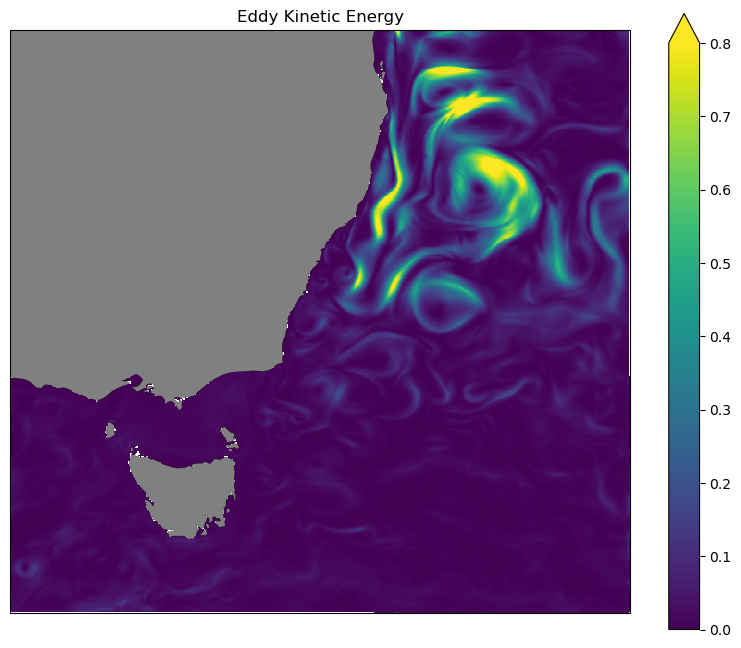

In [75]:
data = EKE
title = 'Eddy Kinetic Energy'
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude=170))

data[100,:].plot(ax=ax, transform=ccrs.PlateCarree(),vmax=0.8)

ax.add_feature(land_50m)
# ax.add_outline_patch.set_linewidth(0.5)
ax.set_title(title)

In [76]:
EKE_mean = EKE.mean('time')

Text(0.5, 1.0, 'Eddy Kinetic Energy')

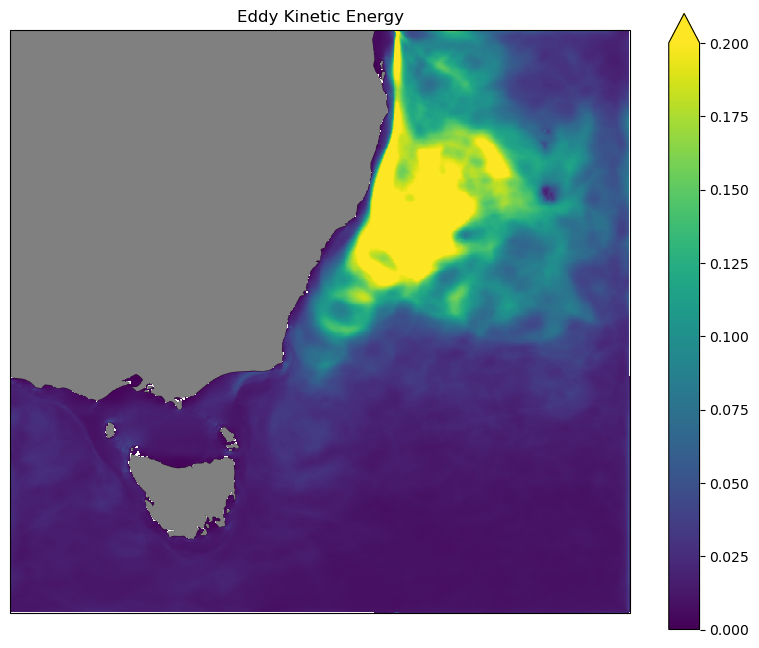

In [79]:
data = EKE_mean
title = 'Eddy Kinetic Energy'
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude=170))

data.plot(ax=ax, transform=ccrs.PlateCarree(),vmax=0.2)

ax.add_feature(land_50m)
# ax.add_outline_patch.set_linewidth(0.5)
ax.set_title(title)

In [82]:
EKE_std = EKE.std('time')

Text(0.5, 1.0, 'Eddy Kinetic Energy')

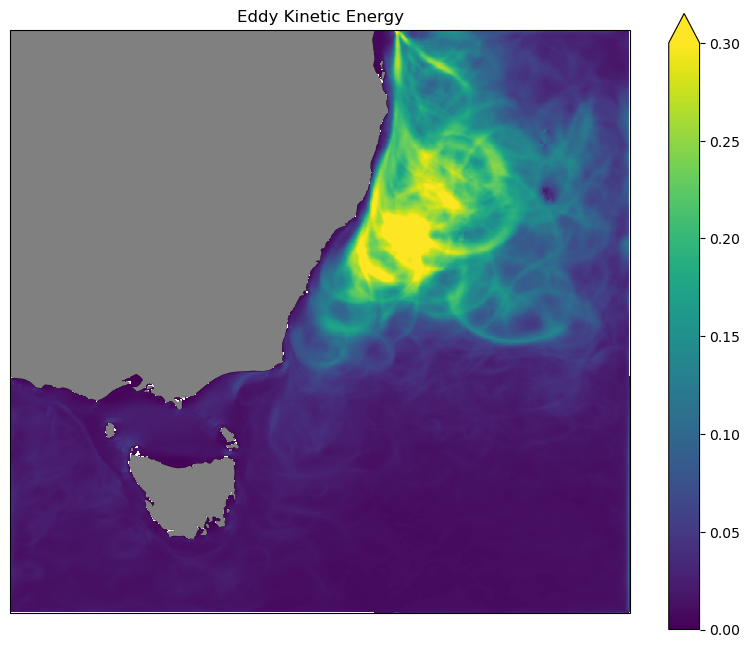

In [85]:
data = EKE_std
title = 'Eddy Kinetic Energy'
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude=170))

data.plot(ax=ax, transform=ccrs.PlateCarree(),vmax=0.3)

ax.add_feature(land_50m)
# ax.add_outline_patch.set_linewidth(0.5)
ax.set_title(title)

Perhaps now is a good time to make a quick overview plot that has mean velocities as arrows, and temp/sea-level anomaly as shading.

In [53]:
%%time
access_speed = np.sqrt(access_daily['u']**2 + access_daily['v']**2)
sthpac_speed = sthpac_daily['speed']
eac_speed = eac_daily['speed']
# Print dims;
print(f'access dims: {access_speed.shape}; \n sthpac dims: {sthpac_speed.shape}; \n eac dims: {eac_speed.shape}')

access dims: (1826, 252, 214); 
 sthpac dims: (1826, 253, 215); 
 eac dims: (1826, 759, 645)
CPU times: user 18.9 ms, sys: 4.48 ms, total: 23.4 ms
Wall time: 22.4 ms


Now a quick summary of the theory for decomposing KE;
### Decomposing the kinetic energy into time-mean and transient components;
#### Theory:
For a hydrostatic ocean model like MOM6, the relevant KE per unit mass is:
$$
KE = \frac{1}{2} (u^2 + v^2)
$$
i.e., proportional to the squared speed...

The vertical velocity component, $w$ does not appear in the mechanical energy budget. It is very much subdominant. But more fundamentally, it simply does not appear in the mechanical budget for a hydrostatic ocean.

For a non-steady fluid, we can define the time-averaged KE as the **Total KE**:
$$
TKE = <KE> = \frac{1}{T} \int^T_0 \frac{1}{2}(u^2+v^2)dt
$$

It is useful to decompose the velocity into time-mean and time-varying components, e.g., 
$$
u = \bar{u} + u'
$$
The **mean kinetic energy** is the energy associated with the mean flow;
$$ 
MKE = \frac{1}{2}(\bar{u}^2 + \bar{v}^2)
$$
The kinetic energy of the time-varying component is the **eddy kinetic energy**, EKE. This quantity can be obtained by subtracting the velocity means, and calculating the KE of the perturbation velocity quantities:
$$
EKE = \bar{\frac{1}{2}[(u-\bar{u})^2+(v-\bar{v})^2]}
$$
MKE and EKE partition the total kinetic energy.
$$
TKE = MKE + EKE
$$

In [54]:
%%time
# mean speeds...
access_speed_mean = access_speed.mean('time').compute()
sthpac_speed_mean = sthpac_speed.mean('time').compute()
eac_speed_mean = eac_speed.mean('time').compute()

CPU times: user 16.6 s, sys: 2.42 s, total: 19.1 s
Wall time: 2min 36s


In [55]:
%%time
# transients / residual...
access_speed_eddy = access_speed - access_speed_mean
sthpac_speed_eddy = sthpac_speed - sthpac_speed_mean
eac_speed_eddy = eac_speed - eac_speed_mean

CPU times: user 25.1 ms, sys: 824 µs, total: 25.9 ms
Wall time: 26.3 ms


In [56]:
%%time
# EDDY KINETIC ENERGY
EKE_access = (0.5*(access_speed_eddy**2)).compute()
EKE_sthpac = (0.5*(sthpac_speed_eddy**2)).compute()
EKE_eac = (0.5*(eac_speed_eddy**2)).compute()

CPU times: user 12.4 s, sys: 7.96 s, total: 20.3 s
Wall time: 1min 3s


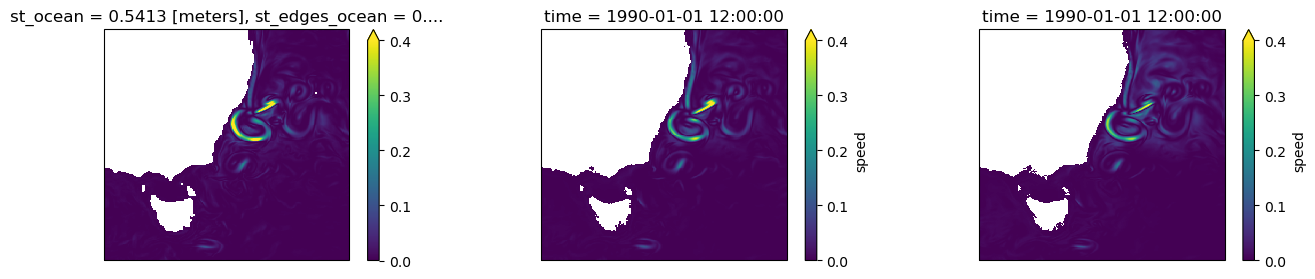

In [65]:
# PLOT SNAPSHOT
fig, axs = plt.subplots(ncols=3, figsize=(16,3), subplot_kw = {'projection':ccrs.PlateCarree()})
EKE_access[0,:].plot(ax=axs[0], vmax=0.4)
EKE_sthpac[0,:].plot(ax=axs[1], vmax=0.4)
EKE_eac[0,:].plot(ax=axs[2], vmax=0.4)

In [67]:
%%time 
# Calculate Mean over time for each model
EKE_access_mean = EKE_access.mean('time')
EKE_sthpac_mean = EKE_sthpac.mean('time')
EKE_eac_mean = EKE_eac.mean('time')

CPU times: user 3.72 s, sys: 1.44 s, total: 5.16 s
Wall time: 4.64 s


Text(0.5, 1.0, 'EAC-003')

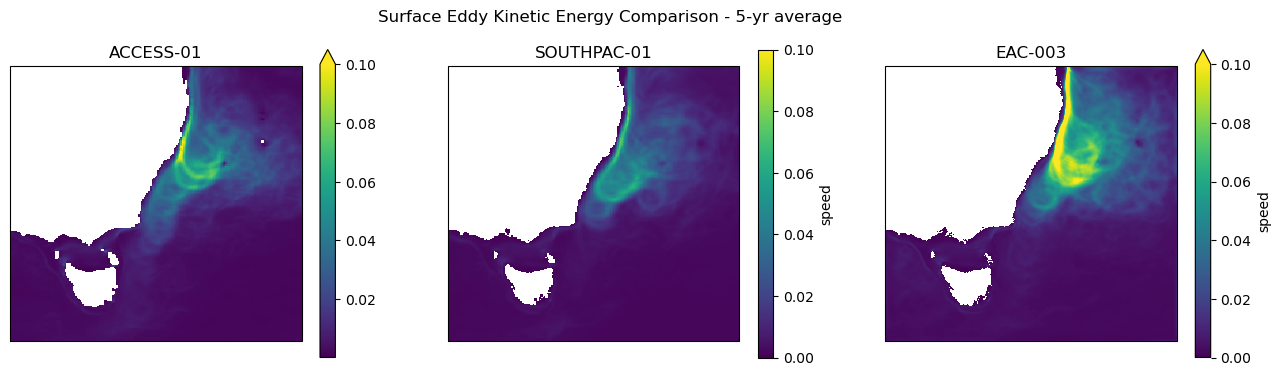

In [76]:
# PLOT AVERAGE OVER TIME
fig, axs = plt.subplots(ncols=3, figsize=(16,4), subplot_kw = {'projection':ccrs.PlateCarree()})
EKE_access_mean.plot(ax=axs[0], vmax=0.1)
EKE_sthpac_mean.plot(ax=axs[1], vmax=0.1)
EKE_eac_mean.plot(ax=axs[2], vmax=0.1)
fig.suptitle('Surface Eddy Kinetic Energy Comparison - 5-yr average')
axs[0].set_title("ACCESS-01")
axs[1].set_title("SOUTHPAC-01")
axs[2].set_title("EAC-003")

I have to bear in mind that these figures are just placeholders and might not show the full story. I'm hoping that when I run the model again, I won't have the spuriously high amplification of poleward velocities at the northern boundary of the EAC jet.

## 2. Compare SSH model output and observations;
Specifically we plot the time-mean and standard deviation of SSH and compare it to those obtained from observations from CMEMS satellite altimetry (former AVISO + dataset). 

In [6]:
om2_ssh,_ = open_iaf_global(input_vars=['eta_t'],
                           decode_times=True)

In [7]:
# import daily data from regional models;
eac_files = glob.glob(eac_003+'output*/*daily.nc')
eac_daily = xr.open_mfdataset(eac_files)
sthpac_files = glob.glob(sthpac_01+ 'output*/*daily.nc')
sthpac_daily = xr.open_mfdataset(sthpac_files)
print(f'date range for eac; {eac_daily.time.min().values} - {eac_daily.time.max().values}')

date range for eac; 1990-01-01 12:00:00 - 1995-11-30 12:00:00


In [8]:
print(f'date range for sthpac; {sthpac_daily.time.min().values} - {sthpac_daily.time.max().values}')

date range for sthpac; 1990-01-01 12:00:00 - 1994-12-31 12:00:00


Right, so we've loaded in all the data. We can see that the smallest date range is from 1990 to the end of 1994 (5 years in total). Let's set this as our date range.

Next we need to subset spatial extent down to the smallest spatial extent which is the SRM (EAC-003) in this case. Let's get the coordinate limits of this and subset the PARENT and LRM models.

In [9]:
date_range = [str(sthpac_daily.time.min().values), str(sthpac_daily.time.max().values)]
# subset PARENT AND EAC in time;
access_daily = om2_ssh.sel(time=slice(date_range[0], date_range[1]))
eac_daily = eac_daily.sel(time=slice(date_range[0], date_range[1]))['zos']

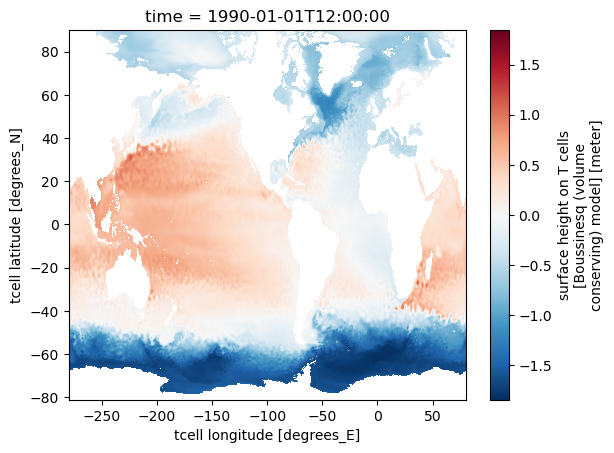

In [10]:
access_daily['eta_t'].isel(time=0).plot()

In [11]:
# spatial extent;
yextent = [eac_daily.yh.min().values, eac_daily.yh.max().values]
xextent = [eac_daily.xh.min().values, eac_daily.xh.max().values]
# subset PARENT AND LRM
access_daily = access_daily.sel(xt_ocean = slice(xextent[0], xextent[1]), 
                           yt_ocean = slice(yextent[0], yextent[1]))['eta_t']
sthpac_daily = sthpac_daily.sel(xh=slice(xextent[0], xextent[1]),
                                yh=slice(yextent[0], yextent[1]))['zos']
print(f'sthpac new dims are: {sthpac_daily.dims}')
print(f'access new dims are: {access_daily.dims}')

sthpac new dims are: ('time', 'yh', 'xh')
access new dims are: ('time', 'yt_ocean', 'xt_ocean')


### Load CMEMS satellite observational data;
Load the CMEMS dataset and select `adt` the sea surface height variable name.

In [12]:
filenames = glob.glob("/g/data/ua8/CMEMS_SeaLevel/timeseries/*.nc")
cmems = xr.open_mfdataset(filenames, parallel=True)

obs_ssh = cmems.adt
obs_ssh = obs_ssh.sel(time=slice(date_range[0], date_range[1]), 
                      latitude=slice(yextent[0], yextent[1]),
                      longitude=slice(xextent[0]+360, xextent[1]+360))
obs_ssh = obs_ssh.rename('adt_cmems')
obs_ssh

<xarray.DataArray 'adt_cmems' (time: 730, latitude: 81, longitude: 86)>
dask.array<getitem, shape=(730, 81, 86), dtype=float64, chunksize=(365, 81, 86), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1994-12-31
  * longitude  (longitude) float32 140.6 140.9 141.1 141.4 ... 161.4 161.6 161.9
  * latitude   (latitude) float32 -46.12 -45.88 -45.62 ... -26.62 -26.38 -26.12
Attributes:
    standard_name:  sea_surface_height_above_geoid
    long_name:      Absolute dynamic topography
    units:          m
    grid_mapping:   crs
    comment:        The absolute dynamic topography is the sea surface height...

## Pre-processing
So based on the discussions with ChrisC, in order to make a robust comparison between the high-resolution model output and the altimetry observations, we need to do a bit of preprocessing. The key reason for this based on how the altimetry dataset was created - Spatially, the swaths that provide the data are relatively sparse, whilst the resolution achieved by the gridded product is through a weighted interpolation of the data in the swath tracks. For this reason, the variance captured by the altimetry is actually in itself, an underestimate of the true surface height variability. Hence, to account for this, we re-grid the high-resolution output to the coarser altimetry grid before calculating variance characteristics. Chris mentioned this is somewhat to ensure that the variance we calculate is true and not a spurious result of the high resolution model. Temporally, due to the intermittent swaths, satellite data is more like weekly snapshots rather than daily output. This means that we should really look at resampling the daily MOM6 data to a weekly metric (either mean, median, snapshot etc.). 

In [ ]:
# input grid - eac-003
eac_raw = eac_daily.rename({'yh':'lat','xh':'lon'})
sthpac_raw = sthpac_daily.rename({'yh':'lat','xh':'lon'})
access_raw = access_daily.rename({'yt_ocean':'lat','xt_ocean':'lon'})
access_raw = access_raw.chunk({'time':500, 'lat':-1,'lon':-1})

# output grid - obs_ssh
obs_raw = obs_ssh.rename({'latitude':'lat','longitude':'lon'})

datetimeindex = eac_daily.indexes['time'].to_datetimeindex()
eac_raw['time'] = ('time',datetimeindex)
sthpac_raw['time'] = ('time',datetimeindex)
access_raw['time'] = ('time',datetimeindex)

# regrid eac and sthpac to obs
regridder_eac = xesmf.Regridder(eac_raw, obs_raw, method='bilinear')
regridder_sthpac = xesmf.Regridder(sthpac_raw, obs_raw, method='bilinear')
regridder_access = xesmf.Regridder(access_raw, obs_raw, method='bilinear')

# regrid datasets;
eac_regridded = regridder_eac(eac_raw)
sthpac_regridded = regridder_sthpac(sthpac_raw)
access_regridded = regridder_access(access_raw)

In [36]:
## Resampling to 5-day averages...
eac_regridded_resampled = eac_regridded.resample(time='5D').mean()
sthpac_regridded_resampled = sthpac_regridded.resample(time='5D').mean()
access_regridded_resampled = access_regridded.resample(time='5D').mean()

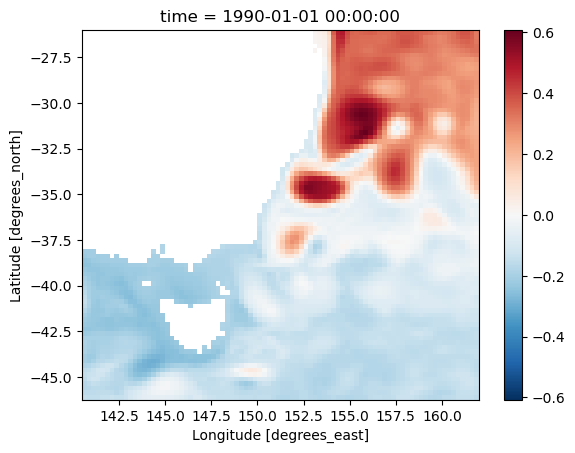

In [43]:
eac_regridded_resampled.isel(time=0).plot()

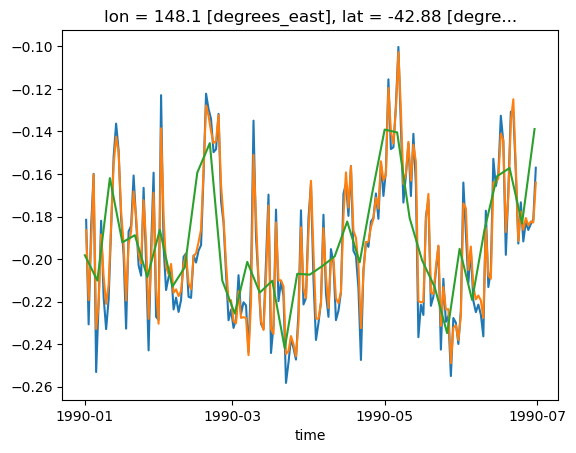

In [44]:
start = '1990-01'
end = '1990-06'
coord = [148, -43]
eac_ls = [eac_daily, eac_regridded, eac_regridded_resampled]
sthpac_ls = [sthpac_daily, sthpac_regridded, sthpac_regridded_resampled]

for i in range(3):
    try:
        ds = eac_ls[i].sel(time=slice(start,end)).sel(lat=coord[1],lon=coord[0],method='nearest')
    except:
        ds = eac_ls[i].sel(time=slice(start,end)).sel(yh=coord[1],xh=coord[0]-360,method='nearest')
    ds.plot()

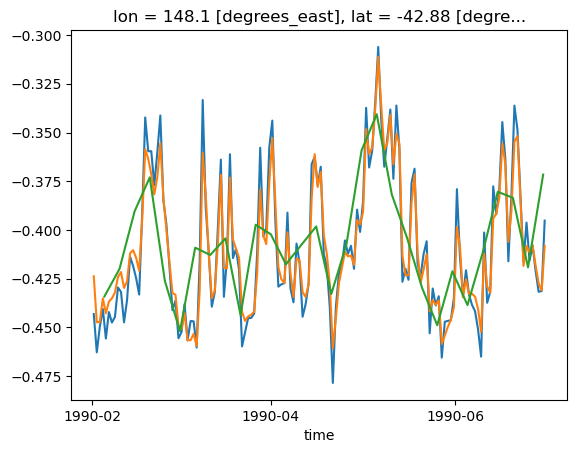

In [46]:
start = '1990-02'
end = '1990-06'
coord = [148, -43]
sthpac_ls = [sthpac_daily, sthpac_regridded, sthpac_regridded_resampled]

for i in range(3):
    try:
        ds = sthpac_ls[i].sel(time=slice(start,end)).sel(lat=coord[1],lon=coord[0],method='nearest')
    except:
        ds = sthpac_ls[i].sel(time=slice(start,end)).sel(yh=coord[1],xh=coord[0]-360,method='nearest')
    ds.plot()

Right so this plot shows the impact of both the remap and regrid on a specific 1D time series. The regrid (orange) removes the very fine-scale variability from the high-resolution by smoothing this out in space, whilst the resample has a greater impact on smoothing out the temporal variability. 

Now let's compare this to the observational dataset and hopefully this will be a fairer comparison.

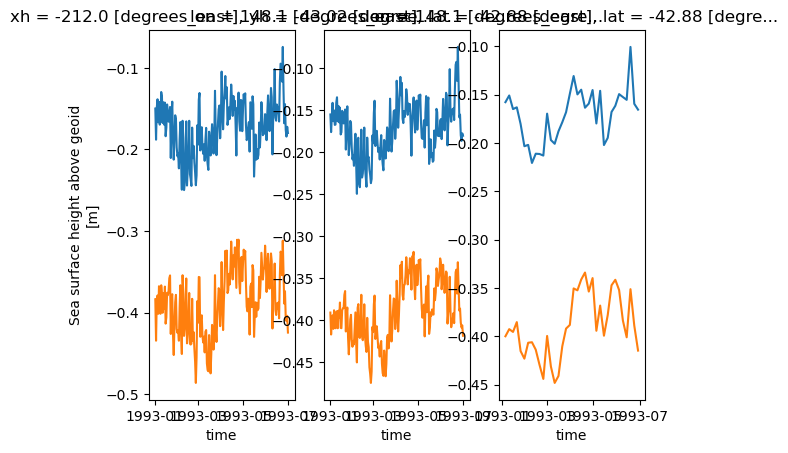

In [59]:
start = '1993-01'
end = '1993-06'
coord = [148, -43]
sthpac_ls = [sthpac_daily, sthpac_regridded, sthpac_regridded_resampled]

for i in range(3):
    plt.subplot(1,3,i+1)
    try:
        ds_eac = eac_ls[i].sel(time=slice(start,end)).sel(lat=coord[1],lon=coord[0],method='nearest')
        ds_sthpac = sthpac_ls[i].sel(time=slice(start,end)).sel(lat=coord[1],lon=coord[0],method='nearest')
    except:
        ds_eac = eac_ls[i].sel(time=slice(start,end)).sel(yh=coord[1],xh=coord[0]-360,method='nearest')
        ds_sthpac = sthpac_ls[i].sel(time=slice(start,end)).sel(yh=coord[1],xh=coord[0]-360,method='nearest')
    ds_eac.plot(label='eac'); ds_sthpac.plot(label='sthpac')
    

In [41]:
# Let's firstly subtract the means away from each dataset in order to normalise them...
d_mean_anom = []
for d in [access_regridded_resampled, sthpac_regridded_resampled, eac_regridded_resampled, obs_raw]:
    d_mean = d.mean('time')
    d_anom = d - d_mean
    d_mean_anom.append((d_mean, d_anom))

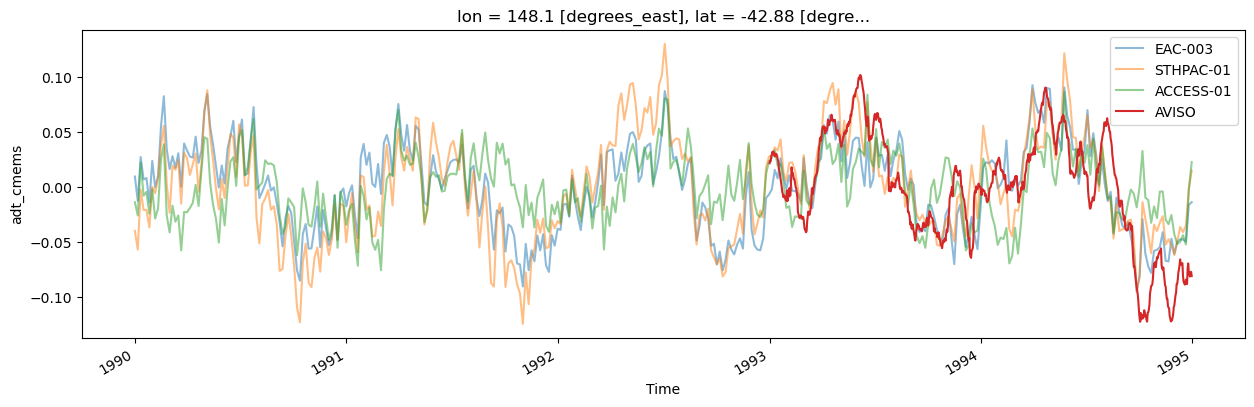

In [49]:
# Plot the regridded/resampled model and obs at specific point
start = '1990-01'
end = '1995-06'
coord = [148, -43]
alpha = [.5, .5, .5, 1.0]
plt.figure(figsize=(15,4))

for i, name in enumerate(['EAC-003','STHPAC-01', 'ACCESS-01', 'AVISO']):
    d_mean_anom[i][1].sel(time=slice(start, end)).sel(lon=coord[0], lat=coord[1],method='nearest').plot(label=name, alpha=alpha[i])
plt.legend()

Some comments on this - What's being shown is 6 months from Jan 1993 to July 1993 of SSH from the model output of EAC-003 and STHPAC-01 as well as observations. The model output has been downsampled (5-day averages) in time, and coarsened in space in an attempt to account for the way the Observational dataset has been pre-processed (See comments above). What we can see here is that for the specific small region chosen, the slow change in observations is represented well in the models, whilst the shorter period fluctuations vary between each time-series. Interstingly, the STHPAC-01 almost looks to be better at representing the AVISO data. 

This plot is more of a sanity check then anything else. Let's now make some spatial maps to show the variance across the region in all three datasets. 

### Spatial Maps

In [45]:
# Plot the regridded/resampled model and obs at specific point
start = '1990-01'
end = '1995-06'
stdev_ls = []
for i, name in enumerate(['ACCESS-01','STHPAC-01','EAC-003', 'AVISO']):
    ds = d_mean_anom[i][1].sel(time=slice(start, end))
    stdev_ls.append(ds.std(dim='time', skipna=False))
    

Text(0.5, 0.98, 'SSH Standard Deviation | First 5-yrs (1990-01 to 1994-12)')

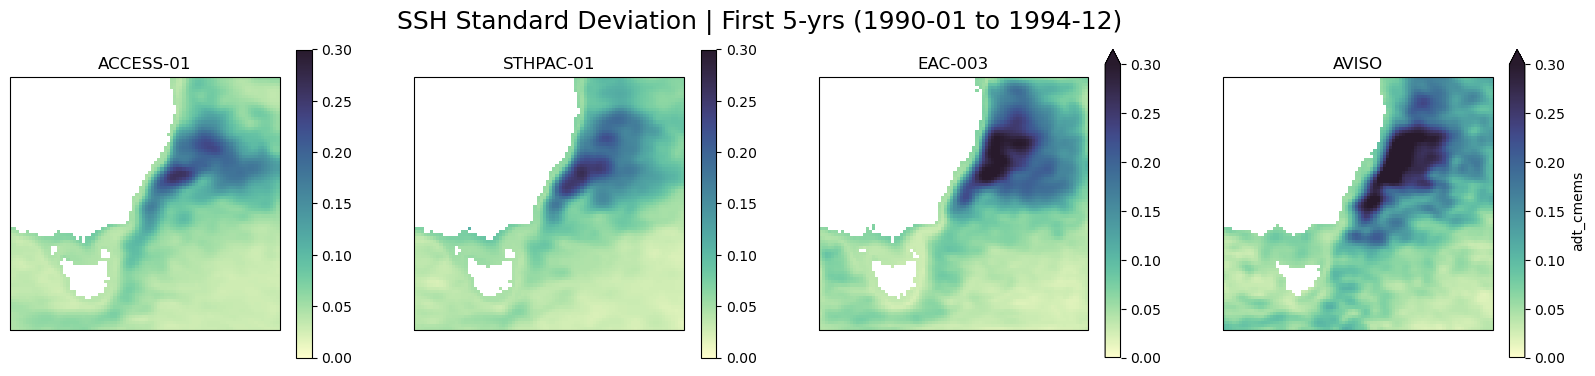

In [46]:
model_names = ['ACCESS-01',  'STHPAC-01','EAC-003', 'AVISO']
projection = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4),
                         subplot_kw={'projection':projection})
max_std=0.3
# stdev SSH plots
for i, ax in enumerate(axes.flatten()):
    p = stdev_ls[i].plot(ax=ax, cmap=cm.cm.deep,
                        vmin=0, vmax=max_std, 
                        add_colorbar=True)
    ax.set_title(model_names[i])
fig.suptitle('SSH Standard Deviation | First 5-yrs (1990-01 to 1994-12)', fontsize=18)

In [ ]:
%%time
model_ls = [access_daily, sthpac_daily, eac_daily]
mean_ls = []
std_ls = []
for model in model_ls:
    model_mean = model.mean(dim='time').load()
    model_std = model.std(dim='time', skipna=False).load()
    mean_ls.append(model_mean)
    std_ls.append(model_std)
    print(f"finished {str(model.name)}")

finished eta_t
finished zos
finished zos
CPU times: user 6.46 s, sys: 870 ms, total: 7.33 s
Wall time: 43.5 s


In [ ]:
%%time
obs_ssh_mean = obs_ssh.mean(dim='time').load()
obs_ssh_std = obs_ssh.std(dim='time').load()


CPU times: user 1.6 s, sys: 257 ms, total: 1.85 s
Wall time: 13.8 s


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [ ]:
# mean_ls.append(obs_ssh_mean)
std_ls.append(obs_ssh_std)

### Plot & Compare
Plot the time-mean and standard deviation of both of the model outputs and the CMEMS observational dataset.

Text(0.5, 0.98, 'Mean daily SSH: First 5-yrs (1990-01 to 1994-12)')

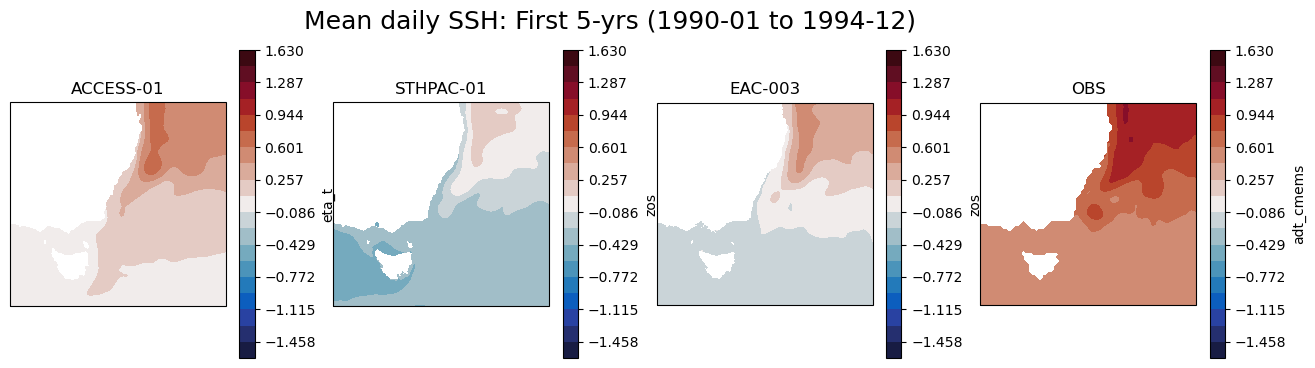

In [20]:
model_names = ['ACCESS-01', 'STHPAC-01', 'EAC-003', 'OBS']
projection = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4),
                         subplot_kw={'projection':projection})
max_std=0.3
max_mean=1.63

# mean SSH plots
for i, ax in enumerate(axes.flatten()):
    p = mean_ls[i].plot.contourf(ax=ax, cmap=cm.cm.balance,
                        vmin=-max_mean, vmax=max_mean, 
                        add_colorbar=True, levels=20)
    ax.set_title(model_names[i])
fig.suptitle('Mean daily SSH: First 5-yrs (1990-01 to 1994-12)', fontsize=18)

Okay, so from the global snapshot earlier, we see that the SSH (`eta_t`) in this case is pretty much positive until around 50 degrees South. This is why we are seeing all positive values for SSH in this region, whereas the regional models seem more well-balanced, i.e., positive anomalies in the northern regions, negative anomalies in the southern regions. But the question is **are the ssh anomalies (`zos`) in the regional models taken relative to some reference level *specific* to the domain limits?** If so, we'd expect the **reference levels to be different** and hence why the mean SSH values look quite different between the two. 

A better understanding of SSH for this circumstance is to look at the variance. 

Text(0.5, 0.98, 'SSH Standard Deviation | First 5-yrs (1990-01 to 1994-12)')

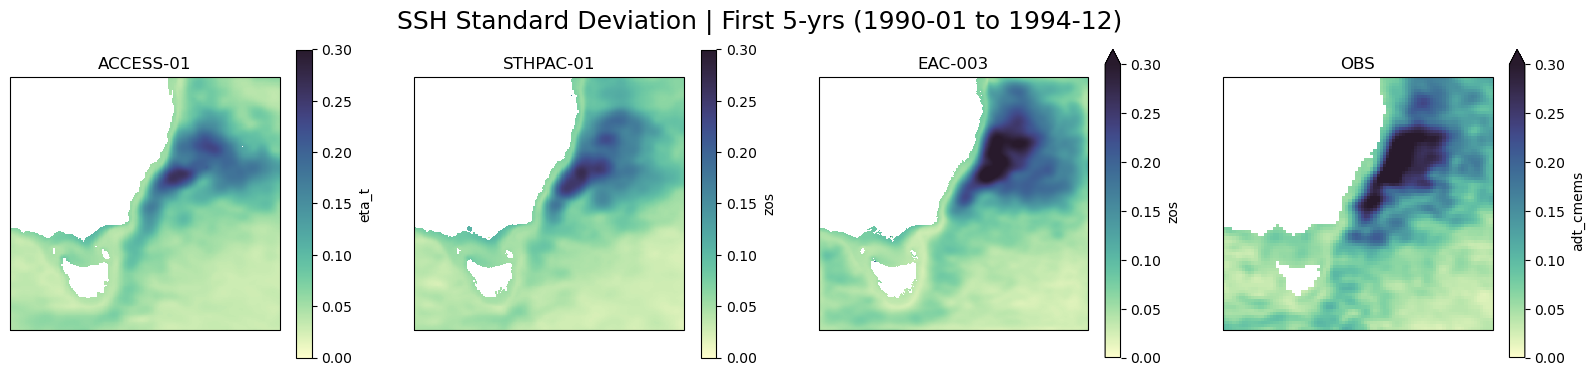

In [27]:
projection = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4),
                         subplot_kw={'projection':projection})
max_std=0.3
max_mean=1.63

# mean SSH plots
for i, ax in enumerate(axes.flatten()):
    p = std_ls[i].plot(ax=ax, cmap=cm.cm.deep,
                        vmin=0, vmax=max_std, 
                        add_colorbar=True)
    ax.set_title(model_names[i])
fig.suptitle('SSH Standard Deviation | First 5-yrs (1990-01 to 1994-12)', fontsize=18)

# 3. Sea Surface Temperature Comparison with NOAA OISST
The approach here will be quite similar to the above approach for SSH. Load in the SST data, run through the preprocessing and then compare with observations.

In [6]:
om2_sst,_ = open_iaf_global(input_vars=['temp'],
                           decode_times=True)
om2_sst

<xarray.Dataset>
Dimensions:         (xt_ocean: 3600, yt_ocean: 2700, st_ocean: 75,
                     st_edges_ocean: 76, time: 2191, nv: 2)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 1990-01-01T12:00:00 ... 1995-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    temp            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(31, 75, 300, 300), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    time_bnds       (time, nv) timedelta64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-3d-temp-1-daily-mean-ym_1990_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221019T1326Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [37]:
# import daily data from regional models;
eac_files = glob.glob(eac_003+'output*/*daily.nc')
eac_daily = xr.open_mfdataset(eac_files)
sthpac_files = glob.glob(sthpac_01+ 'output*/*daily.nc')
sthpac_daily = xr.open_mfdataset(sthpac_files)
print(f'date range for eac; {eac_daily.time.min().values} - {eac_daily.time.max().values}')

date range for eac; 1990-01-01 12:00:00 - 1995-11-30 12:00:00


In [38]:
print(f'date range for sthpac; {sthpac_daily.time.min().values} - {sthpac_daily.time.max().values}')

date range for sthpac; 1990-01-01 12:00:00 - 1994-12-31 12:00:00


Right, so we've loaded in all the data. We can see that the smallest date range is from 1990 to the end of 1994 (5 years in total). Let's set this as our date range.

Next we need to subset spatial extent down to the smallest spatial extent which is the SRM (EAC-003) in this case. Let's get the coordinate limits of this and subset the PARENT and LRM models.

In [39]:
date_range = [str(sthpac_daily.time.min().values), str(sthpac_daily.time.max().values)]
# subset PARENT AND EAC in time;
access_daily = om2_sst.sel(time=slice(date_range[0], date_range[1])).isel(st_ocean=0)['temp']-273.15
eac_daily = eac_daily.sel(time=slice(date_range[0], date_range[1]))['tos']

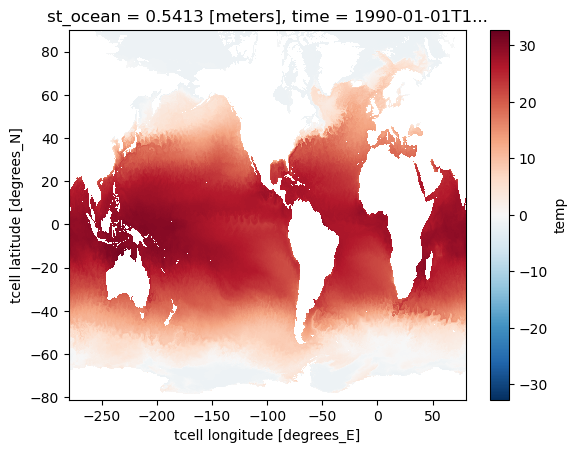

In [40]:
access_daily.isel(time=0).plot()

In [41]:
# spatial extent;
yextent = [eac_daily.yh.min().values, eac_daily.yh.max().values]
xextent = [eac_daily.xh.min().values, eac_daily.xh.max().values]
# subset PARENT AND LRM
access_daily = access_daily.sel(xt_ocean = slice(xextent[0], xextent[1]), 
                           yt_ocean = slice(yextent[0], yextent[1]))
sthpac_daily = sthpac_daily.sel(xh=slice(xextent[0], xextent[1]),
                                yh=slice(yextent[0], yextent[1]))['tos']
# rename lat/lon coords
access_daily = access_daily.rename({'xt_ocean':'lon', 'yt_ocean':'lat'})
sthpac_daily = sthpac_daily.rename({'xh':'lon', 'yh':'lat'})
eac_daily = eac_daily.rename({'xh':'lon', 'yh':'lat'})

print(f'sthpac new dims are: {sthpac_daily.dims}')
print(f'access new dims are: {access_daily.dims}')

sthpac new dims are: ('time', 'lat', 'lon')
access new dims are: ('time', 'lat', 'lon')


#### Import NOAA data

In [12]:
noaa_path = '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/*.nc'
file_list = glob.glob(noaa_path)

In [13]:
file_list.sort()
newlist = []
i=0
while '1990' not in file_list[i]:
    i+=1
first=i
newlist = file_list[first:]
newlist[:5]

['/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_1990.nc',
 '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_1991.nc',
 '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_1992.nc',
 '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_1993.nc',
 '/g/data/ia39/aus-ref-clim-data-nci/oisst/data/yearly/oisst-avhrr-v02r01_1994.nc']

In [27]:
oisst = xr.open_mfdataset(newlist)
oisst = oisst.sel(lat = slice(yextent[0], yextent[1]), 
                  lon = slice(xextent[0]+360, xextent[1]+360))
oisst = oisst.sel(time=slice(date_range[0], date_range[1]))['sst']
oisst['lon'] = oisst.lon - 360
oisst

<xarray.DataArray 'sst' (time: 1826, zlev: 1, lat: 81, lon: 86)>
dask.array<getitem, shape=(1826, 1, 81, 86), dtype=float32, chunksize=(366, 1, 81, 86), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -46.12 -45.88 -45.62 -45.38 ... -26.62 -26.38 -26.12
  * lon      (lon) float32 -219.4 -219.1 -218.9 -218.6 ... -198.6 -198.4 -198.1
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 1994-12-31T12:00:00
  * zlev     (zlev) float32 0.0
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius

Text(0.5, 0.98, 'snapshot | 1991-01-01')

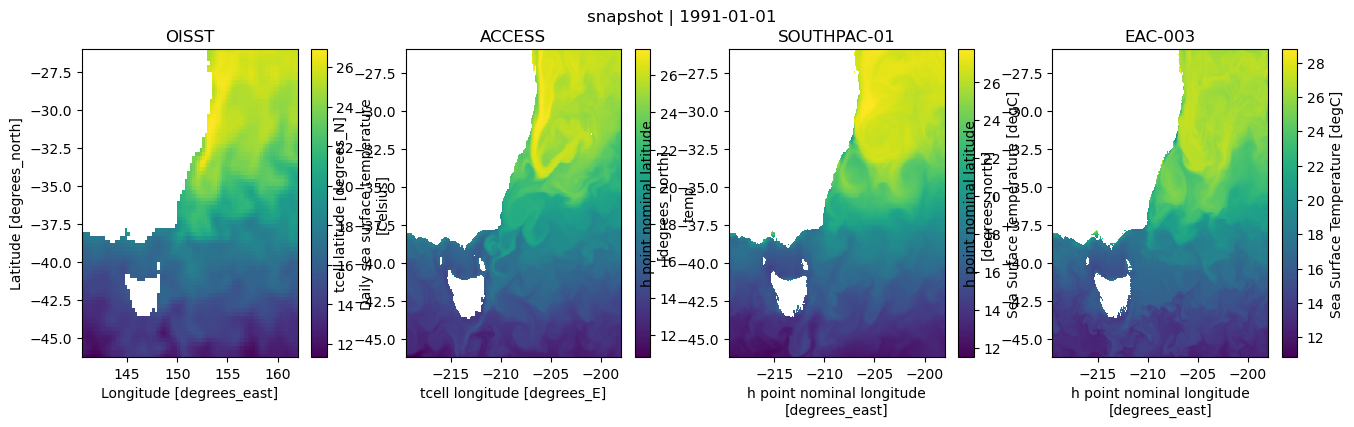

In [23]:
day = '1991-01-01'
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
oisst.sel(time=day).plot()
plt.title('OISST')
plt.subplot(1,4,2)
access_daily.sel(time=day).plot()
plt.title('ACCESS')
plt.subplot(1,4,3)
sthpac_daily.sel(time=day).plot()
plt.title('SOUTHPAC-01')
plt.subplot(1,4,4)
eac_daily.sel(time=day).plot()
plt.title('EAC-003')
plt.suptitle(f'snapshot | {day}')

Right, so in the NOAA dataset, we have both the anomaly and the raw sst. It looks like the anomalies are calculated from the long-term monthly mean climatology from 1991 to 2020. Now, there's a few ways we could do this - 
1. Calculate the monthly climatology for the model output then take anomalies.
2. Just take a single mean and take anomalies from that. This isn't the most scienfically robust way of doing things due to the seasonally variability dominating the overall anomaly but let's just try this first...

In [42]:
# Let's firstly subtract the means away from each dataset in order to normalise them...
d_mean_anom = []
for d in [access_daily, sthpac_daily, eac_daily, oisst]:
    d_mean = d.mean('time')
    d_anom = d - d_mean
    d_mean_anom.append((d_mean, d_anom))

In [44]:
# Plot the regridded/resampled model and obs at specific point
start = '1990-01'
end = '1995-06'
coord = [148, -43]
alpha = [.5, .5, .5, 1.0]
plt.figure(figsize=(15,4))

for i, name in enumerate(['EAC-003','STHPAC-01', 'ACCESS-01', 'AVISO']):
    d_mean_anom[i][1].sel(time=slice(start, end)).sel(lon=coord[0], lat=coord[1],method='nearest').plot(label=name, alpha=alpha[i])

plt.legend()

OverflowError: int too big to convert

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1507a33770d0> (for post_execute):


OverflowError: int too big to convert

OverflowError: int too big to convert

<Figure size 1500x400 with 1 Axes>

Some comments on this - What's being shown is 6 months from Jan 1993 to July 1993 of SSH from the model output of EAC-003 and STHPAC-01 as well as observations. The model output has been downsampled (5-day averages) in time, and coarsened in space in an attempt to account for the way the Observational dataset has been pre-processed (See comments above). What we can see here is that for the specific small region chosen, the slow change in observations is represented well in the models, whilst the shorter period fluctuations vary between each time-series. Interstingly, the STHPAC-01 almost looks to be better at representing the AVISO data. 

This plot is more of a sanity check then anything else. Let's now make some spatial maps to show the variance across the region in all three datasets. 

### Spatial Maps

In [45]:
# Plot the regridded/resampled model and obs at specific point
start = '1990-01'
end = '1995-06'
stdev_ls = []
for i, name in enumerate(['ACCESS-01','STHPAC-01','EAC-003', 'AVISO']):
    ds = d_mean_anom[i][1].sel(time=slice(start, end))
    stdev_ls.append(ds.std(dim='time', skipna=False))
    

Text(0.5, 0.98, 'SSH Standard Deviation | First 5-yrs (1990-01 to 1994-12)')

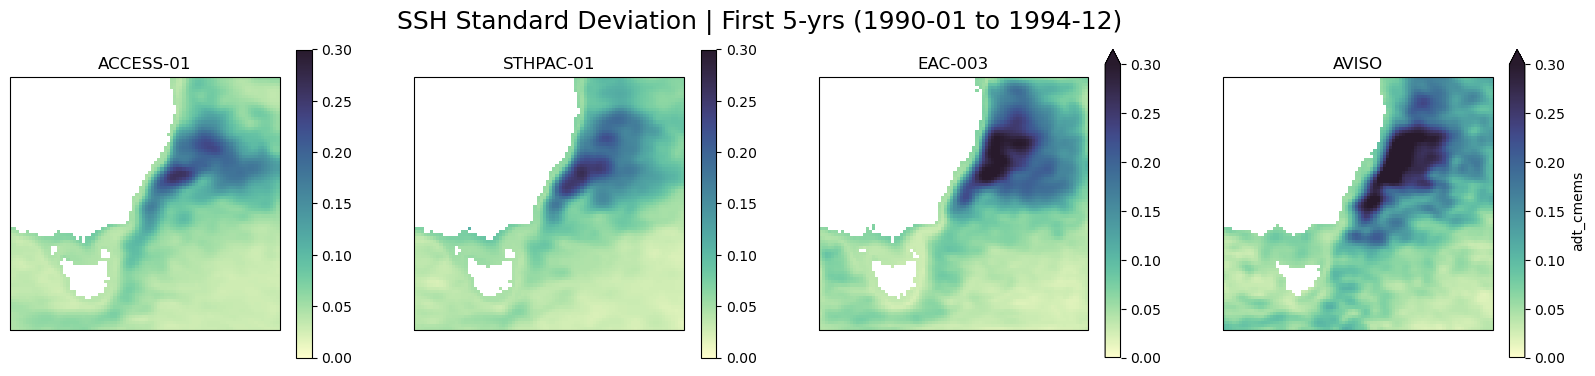

In [46]:
model_names = ['ACCESS-01',  'STHPAC-01','EAC-003', 'AVISO']
projection = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4),
                         subplot_kw={'projection':projection})
max_std=0.3
# stdev SSH plots
for i, ax in enumerate(axes.flatten()):
    p = stdev_ls[i].plot(ax=ax, cmap=cm.cm.deep,
                        vmin=0, vmax=max_std, 
                        add_colorbar=True)
    ax.set_title(model_names[i])
fig.suptitle('SSH Standard Deviation | First 5-yrs (1990-01 to 1994-12)', fontsize=18)

In [ ]:
%%time
model_ls = [access_daily, sthpac_daily, eac_daily]
mean_ls = []
std_ls = []
for model in model_ls:
    model_mean = model.mean(dim='time').load()
    model_std = model.std(dim='time', skipna=False).load()
    mean_ls.append(model_mean)
    std_ls.append(model_std)
    print(f"finished {str(model.name)}")

finished eta_t
finished zos
finished zos
CPU times: user 6.46 s, sys: 870 ms, total: 7.33 s
Wall time: 43.5 s


In [ ]:
%%time
obs_ssh_mean = obs_ssh.mean(dim='time').load()
obs_ssh_std = obs_ssh.std(dim='time').load()


CPU times: user 1.6 s, sys: 257 ms, total: 1.85 s
Wall time: 13.8 s


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [ ]:
# mean_ls.append(obs_ssh_mean)
std_ls.append(obs_ssh_std)

### Plot & Compare
Plot the time-mean and standard deviation of both of the model outputs and the CMEMS observational dataset.

Text(0.5, 0.98, 'Mean daily SSH: First 5-yrs (1990-01 to 1994-12)')

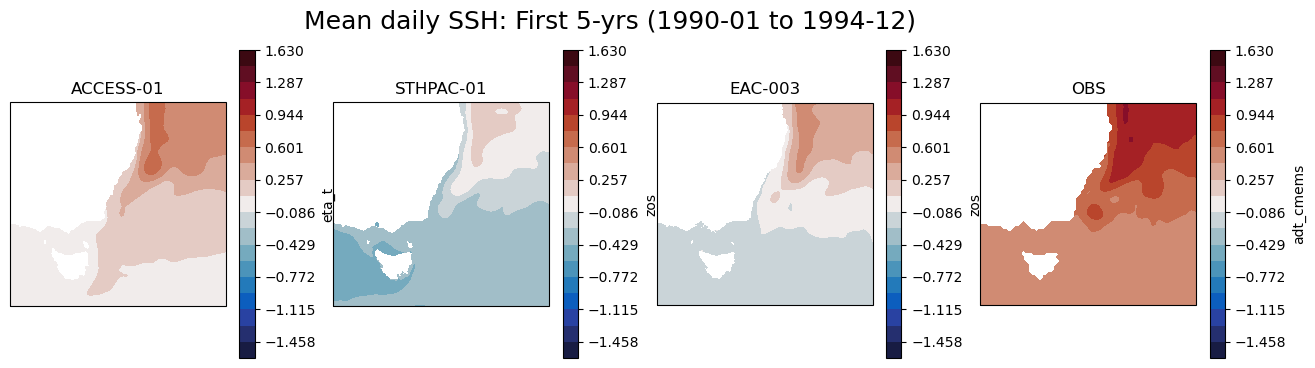

In [20]:
model_names = ['ACCESS-01', 'STHPAC-01', 'EAC-003', 'OBS']
projection = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4),
                         subplot_kw={'projection':projection})
max_std=0.3
max_mean=1.63

# mean SSH plots
for i, ax in enumerate(axes.flatten()):
    p = mean_ls[i].plot.contourf(ax=ax, cmap=cm.cm.balance,
                        vmin=-max_mean, vmax=max_mean, 
                        add_colorbar=True, levels=20)
    ax.set_title(model_names[i])
fig.suptitle('Mean daily SSH: First 5-yrs (1990-01 to 1994-12)', fontsize=18)

Okay, so from the global snapshot earlier, we see that the SSH (`eta_t`) in this case is pretty much positive until around 50 degrees South. This is why we are seeing all positive values for SSH in this region, whereas the regional models seem more well-balanced, i.e., positive anomalies in the northern regions, negative anomalies in the southern regions. But the question is **are the ssh anomalies (`zos`) in the regional models taken relative to some reference level *specific* to the domain limits?** If so, we'd expect the **reference levels to be different** and hence why the mean SSH values look quite different between the two. 

A better understanding of SSH for this circumstance is to look at the variance. 

Text(0.5, 0.98, 'SSH Standard Deviation | First 5-yrs (1990-01 to 1994-12)')

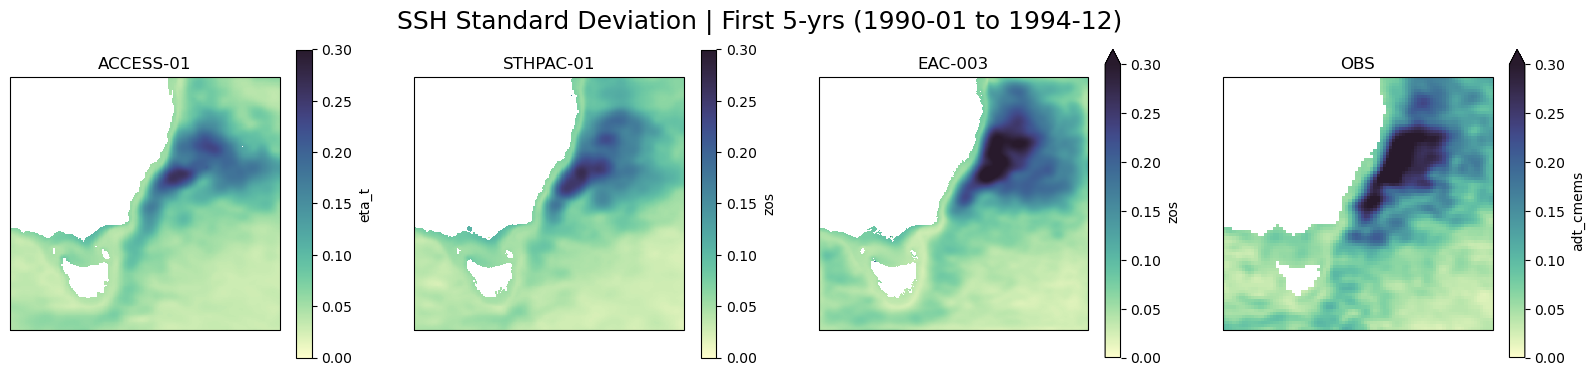

In [27]:
projection = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4),
                         subplot_kw={'projection':projection})
max_std=0.3
max_mean=1.63

# mean SSH plots
for i, ax in enumerate(axes.flatten()):
    p = std_ls[i].plot(ax=ax, cmap=cm.cm.deep,
                        vmin=0, vmax=max_std, 
                        add_colorbar=True)
    ax.set_title(model_names[i])
fig.suptitle('SSH Standard Deviation | First 5-yrs (1990-01 to 1994-12)', fontsize=18)